Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os

Define Cutting Functions

In [2]:
def get_xyzq(event):
    '''
    Truncates the points in an event to only include x, y, z, and q
    '''
    try:
        xyzq = np.empty((len(event), 4))
        xyzq = np.stack((event[:, 0], event[:, 1], event[:, 2], event[:, 4]), axis=-1)
    except:
        xyzq = np.empty((len(event), 3))
        xyzq = np.stack((event[:, 0], event[:, 1], event[:, 2]), axis=-1)

    return xyzq


def restructure(event, fourD):
    '''
    Takes an event and sorts the points by Z
    '''

    if fourD:
        dtype = [('x', float), ('y', float), ('z', float), ('q', float)]
    else:
        dtype = [('x', float), ('y', float), ('z', float)]

    sorted = np.empty((len(event), ), dtype=dtype)

    xs = event[:, 0]
    ys = event[:, 1]
    zs = event[:, 2]
    if fourD:
        qs = event[:, 4]

    for i in range(len(event)):
        if fourD:
            sorted[i] = (xs[i], ys[i], zs[i], qs[i])
        else:
            sorted[i] = (xs[i], ys[i], zs[i])

    sorted = np.sort(sorted, order='z')

    return sorted


def revert(event):
    '''
    Undos the data restructuring by restructure func and shuffles points in event
    '''
    try:
        reverted = np.empty((1, len(event), 4))
        for i in range(len(event)):
            reverted[0, i, 0] = event[i]['x']
            reverted[0, i, 1] = event[i]['y']
            reverted[0, i, 2] = event[i]['z']
            reverted[0, i, 3] = event[i]['q']
    except:    
        reverted = np.empty((1, len(event), 3))
        for i in range(len(event)):
            reverted[0, i, 0] = event[i]['x']
            reverted[0, i, 1] = event[i]['y']
            reverted[0, i, 2] = event[i]['z']

    np.random.default_rng().shuffle(reverted, axis=1)

    return reverted


def random_cut(event, nSliced):
    '''
    Randomly cuts nSliced points from event
    '''

    rng = np.random.default_rng()
    
    slice_idx = int(rng.random() * len(event))
    # Ensure no out of bounds indexing
    while slice_idx > (len(event) - nSliced):
        slice_idx = int(rng.random() * len(event))

    last_idx = slice_idx + nSliced

    return np.delete(event, np.s_[slice_idx:last_idx], axis=0)


def middle_cut(event, nSliced):
    '''
    Cuts out nSliced points from the middle of event
    '''
    
    low = len(event)//2 - nSliced//2
    high = low + nSliced
    # assert low == len(event)//4 and high == 3*low, f'low == {low} -- high == {high}'

    return np.delete(event, np.s_[low:high], axis=0)


def half_cut(event):
    '''
    Cuts an event in half z wise
    '''

    return event[:len(event)//2]

Define Scaling/Visualizing Functions

In [3]:
def down_scale(event):
    '''
    Down scales event
    '''

    RANGES = {
            'MIN_X': -270.0,
            'MAX_X': 270.0,
            'MIN_Y': -270.0,
            'MAX_Y': 270.0,
            'MIN_Z': -185.0,
            'MAX_Z': 1155.0,
            'MIN_LOG_A': 0.0,
            'MAX_LOG_A': 8.60
        }
    
    event[:, 0] = (event[:, 0] - RANGES['MIN_X']) / (RANGES['MAX_X'] - RANGES['MIN_X'])
    event[:, 1] = (event[:, 1] - RANGES['MIN_Y']) / (RANGES['MAX_Y'] - RANGES['MIN_Y'])
    event[:, 2] = (event[:, 2] - RANGES['MIN_Z']) / (RANGES['MAX_Z'] - RANGES['MIN_Z'])
    try:
        event[:, 3] = (np.log(event[:, 3]) - RANGES['MIN_LOG_A'])/(RANGES['MAX_LOG_A'] - RANGES['MIN_LOG_A'])
    except:
        pass

    return event


def up_scale(event, scaleQ=True):
    '''
    Undos down_scale func
    '''

    RANGES = {
            'MIN_X': -270.0,
            'MAX_X': 270.0,
            'MIN_Y': -270.0,
            'MAX_Y': 270.0,
            'MIN_Z': -185.0,
            'MAX_Z': 1155.0,
            'MIN_LOG_A': 0.0,
            'MAX_LOG_A': 8.60
        }
    
    event[:, 0] = event[:, 0] * (RANGES['MAX_X'] - RANGES['MIN_X']) + RANGES['MIN_X']
    event[:, 1] = event[:, 1] * (RANGES['MAX_Y'] - RANGES['MIN_Y']) + RANGES['MIN_Y']
    event[:, 2] = event[:, 2] * (RANGES['MAX_Z'] - RANGES['MIN_Z']) + RANGES['MIN_Z']
    if scaleQ:
        event[:, 3] = np.exp(event[:, 3]) * (RANGES['MAX_Z'] - RANGES['MIN_Z']) + RANGES['MIN_Z']
    else:
        pass

    return event


def scaled_vis(event, showcolor=True):
    '''
    Makes a scatter plot with fixed AT-TPC axes, assumes up scaled event
    '''

    xs = event[:, 0]
    ys = event[:, 1]
    zs = event[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    try:
        if showcolor:
            qs = event[:, 3]
            sc = ax.scatter(xs, zs, ys, c=qs, cmap='jet', s=1)
            fig.colorbar(sc)
        else:
            ax.scatter(xs, zs, ys, s=1)
    except:
        ax.scatter(xs, zs, ys, s=1)
    ax.set_xlabel('X')
    ax.set_zlabel('Y')
    ax.set_ylabel('Z')

    RANGES = {
            'MIN_X': -270.0,
            'MAX_X': 270.0,
            'MIN_Y': -270.0,
            'MAX_Y': 270.0,
            'MIN_Z': -185.0,
            'MAX_Z': 1155.0
        }

    ax.set_xlim(xmin=RANGES['MIN_X'], xmax=RANGES['MAX_X'])
    ax.set_ylim(ymin=RANGES['MIN_Z'], ymax=RANGES['MAX_Z'])
    ax.set_zlim(zmin=RANGES['MIN_Y'], zmax=RANGES['MAX_Y'])

    plt.show()
    # plt.savefig('path.png')

    return


def unscaled_vis(event, showcolor=True):

    xs = event[:, 0]
    ys = event[:, 1]
    zs = event[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    try:
        if showcolor:
            qs = event[:, 3]
            sc = ax.scatter(xs, zs, ys, c=qs, s=1,  cmap='jet')
            fig.colorbar(sc)
        else:
            ax.scatter(xs, zs, ys, s=1)
    except:
        ax.scatter(xs, zs, ys)
    ax.set_xlabel('X')
    ax.set_zlabel('Y')
    ax.set_ylabel('Z')

    plt.show()

    return


Define files to cut, numbers of points to cut, number of cuts, and what kind of cut

In [4]:
# Set Cutting Parameters
nComplete = 512
nCut = 128
num_cuts = 1

# Set Cut Type
rand = True
mid = False
if mid:
    assert num_cuts == 1, 'Middle cutting requires 1 cut'
half = False
if half:
    assert num_cuts == 1, 'Half cut requires 1 cut'
include_qs = False

assert os.getcwd() == '/home/DAVIDSON/bewagner/summer2023/ATTPCPoinTr/data', f'Current Working Directory == {os.getcwd()}'
root = os.getcwd() + f'/22Mg-16O-combo/'

# Set Files to Cut
files = [root+'all_my_events.npy']

out_root = os.getcwd() + f'/22Mg-16O-combo/'

In [5]:
for file in files:

    f = np.load(file)
    xyzq = get_xyzq(f[0])
    # scaled_vis(up_scale(xyzq, scaleQ=False))
    # scaled_vis(up_scale(down_scale(xyzq), scaleQ=False))

    cut_per_slice = nCut // num_cuts

    sliced_file = restructure(f[0], include_qs)

    if mid:
        sliced_file = middle_cut(sliced_file, nCut)
    elif rand:
        for i in range(num_cuts):
            sliced_file = random_cut(sliced_file, cut_per_slice)
    elif half:
        sliced_file = half_cut(sliced_file)
    else:
        raise AssertionError('mid and rand cannot both be False')
            
    sliced_file = revert(sliced_file)
    

    for i in range(1, len(f)):
        
        sliced_event = restructure(f[i], include_qs)

        if mid:
            sliced_event = middle_cut(sliced_event, nCut)
        elif rand:
            for i in range(num_cuts):
                sliced_event = random_cut(sliced_event, cut_per_slice)
        elif half:
            sliced_event = half_cut(sliced_event)

        sliced_event = revert(sliced_event)

        sliced_file = np.vstack((sliced_file, sliced_event))
    

    # if 'train' in file:
    #     split = 'train.npy'
    #     # unscaled_vis(up_scale(sliced_file[2], scaleQ=False), showcolor=False)
    #     # unscaled_vis(up_scale(f[2], scaleQ=False), showcolor=False)
    # elif 'test' in file:
    #     split = 'test.npy'
    #     # scaled_vis(up_scale(sliced_file[0]))
    #     # scaled_vis(up_scale(f[0]))
    # elif 'val' in file:
    #     split = 'val.npy'
    #     # scaled_vis(up_scale(sliced_file[0]))
    #     # scaled_vis(up_scale(f[0]))

    if mid:
        np.save(f'{out_root}mid_cut_Mg22_{split}', sliced_file)
    elif rand:
        np.save(f'{out_root}all_my_cut_events.npy', sliced_file)
    elif half:
        np.save(f'{out_root}half_cut_Mg22_{split}', sliced_file)
    print(f'{split} file saved')
    print(sliced_file.shape)

NameError: name 'split' is not defined

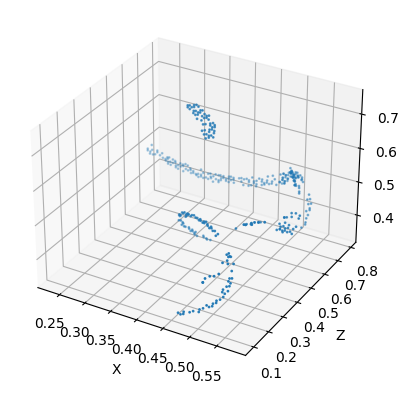

In [15]:
unscaled_vis(np.load(out_root+'mid_cut_Mg22_'+split)[0], showcolor=False)

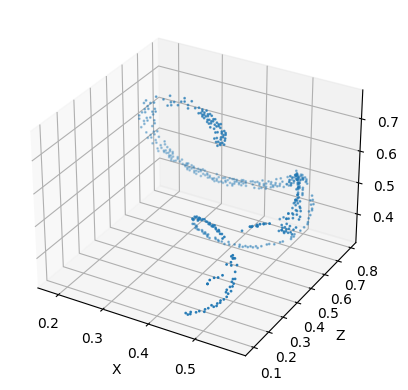

In [16]:
unscaled_vis(np.load(files[-1])[0], showcolor=False)